# Wall detection

In [29]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.core import *

In [31]:
path = Path("data")
path.ls()

[PosixPath('data/walllabels'),
 PosixPath('data/images'),
 PosixPath('data/wallmasks')]

In [32]:
path_lbl = path/'walllabels'
path_img = path/'images'

# Data

In [33]:
fnames = get_image_files(path_img)
# fnames[:3]

In [34]:
lbl_names = get_image_files(path_lbl)
# lbl_names[:3]

In [35]:
img_f = fnames[0]
img = open_image(img_f)
# img.show(figsize=(10,10))

In [36]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [37]:
mask = open_mask(get_y_fn(img_f))
# mask.show(figsize=(10,10), alpha=1)

In [38]:
src_size = np.array(mask.shape[1:])
#src_size,mask.data

In [39]:
codes = ['wall', 'not-wall']; codes

['wall', 'not-wall']

# Datasets

In [40]:
size = src_size//8
print(f"size: {size}")

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

size: [922 708]
using bs=4, have 9538MB of GPU RAM free


In [41]:
#transforms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_zoom=2, p_affine=1)
transforms=get_transforms()

In [42]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(valid_pct=0.1, seed=1)
       .label_from_func(get_y_fn, classes=codes))

In [43]:
data = (src.transform(transforms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [44]:
# def _plot(i,j,ax):
#     x,y = data.train_ds[1]
#     x.show(ax, y=y)

# plot_multi(_plot, 3, 3, figsize=(8,8))

In [45]:
#data.show_batch(3, figsize=(10,7))

In [46]:
#data.show_batch(3, figsize=(10,7), ds_type=DatasetType.Valid)

# Model

In [47]:
name2id = {v:k for k,v in enumerate(codes)}
wall_code = name2id['wall']

#def acc_camvid(input, target):
#    target = target.squeeze(1)
#    mask = target != void_code
#    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
def acc_wall(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def precision(input, target):
    # remove the channel dimension (?)
    target = target.squeeze(1)
    input = input.argmax(dim=1)
    mask = input == wall_code
    return (input[mask]==target[mask]).float().mean()

def recall(input, target):
    target = target.squeeze(1)
    mask = target == wall_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
    

In [48]:
# test the metrics
input = tensor([[1,0,0],[1,1,1]],[[0, 1, 1], [0, 0, 0]])
target = tensor([1, 1, 1], [0, 0, 0])
print(precision(input[None], target[None][None])) # add batch dimension to input and batch and channel dimension to target
recall(input[None], target[None][None])

tensor(0.7500)


tensor(1.)

In [49]:
metrics=[acc_wall, precision, recall]
#metrics=acc_wall

In [50]:
wd=1e-2

In [51]:
def cuda_mem_usage():
    max_mem = torch.cuda.max_memory_allocated()
    mem = torch.cuda.memory_allocated()
    print(f"max_mem: {max_mem}, mem: {mem}")

In [52]:
learn = None
gc.collect()
cuda_mem_usage()
print(f"metrics: {metrics}, wd: {wd}")
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()
cuda_mem_usage()

max_mem: 10179261440, mem: 0
metrics: [<function acc_wall at 0x7fd4eaa38ae8>, <function precision at 0x7fd4eaa389d8>, <function recall at 0x7fd4eaa38950>], wd: 0.01
max_mem: 10179261440, mem: 86260224


In [54]:
# lr_find(learn)
# learn.recorder.plot()
# cuda_mem_usage()

In [55]:
lr=3e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_wall,precision,recall,time
0,0.101660,0.057341,0.985538,0.881060,0.644133,00:28
1,0.064851,0.031939,0.989711,0.925216,0.753808,00:28
2,0.047735,0.025344,0.990034,0.910792,0.776865,00:29
3,0.037852,0.022421,0.991701,0.939056,0.799583,00:29
4,0.033025,0.022979,0.990783,0.949017,0.767678,00:30
5,0.028245,0.019784,0.992469,0.888605,0.875194,00:29
6,0.025470,0.019663,0.992792,0.879331,0.899698,00:28
7,0.023934,0.018091,0.992835,0.923731,0.851176,00:29
8,0.022702,0.020849,0.992275,0.967193,0.793564,00:31
9,0.020170,0.015623,0.994159,0.944789,0.871261,00:29


In [56]:
learn.save('stage-1')

In [57]:
learn.load('stage-1');

In [58]:
# learn.destroy()
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()
# learn.load('stage-1')

In [59]:
def show_results():
    n_valid = len(data.valid_ds)
    figsize = (15, n_valid*5)
    fig,axs = plt.subplots(n_valid, 3, figsize=figsize)
    for i,(x,y) in enumerate(data.valid_ds):
        x.show(ax=axs[i,0], figsize=(5,5))
        y.show(ax=axs[i,1], figsize=(5,5))
        pred, label, raw = learn.predict(x)
        r = recall(raw[None], y.px[None])
        p = precision(raw[None], y.px[None])
        pred.show(ax=axs[i,2], figsize=(5,5), title=f"recall: {r:.2f}, precision: {p:.2f}")

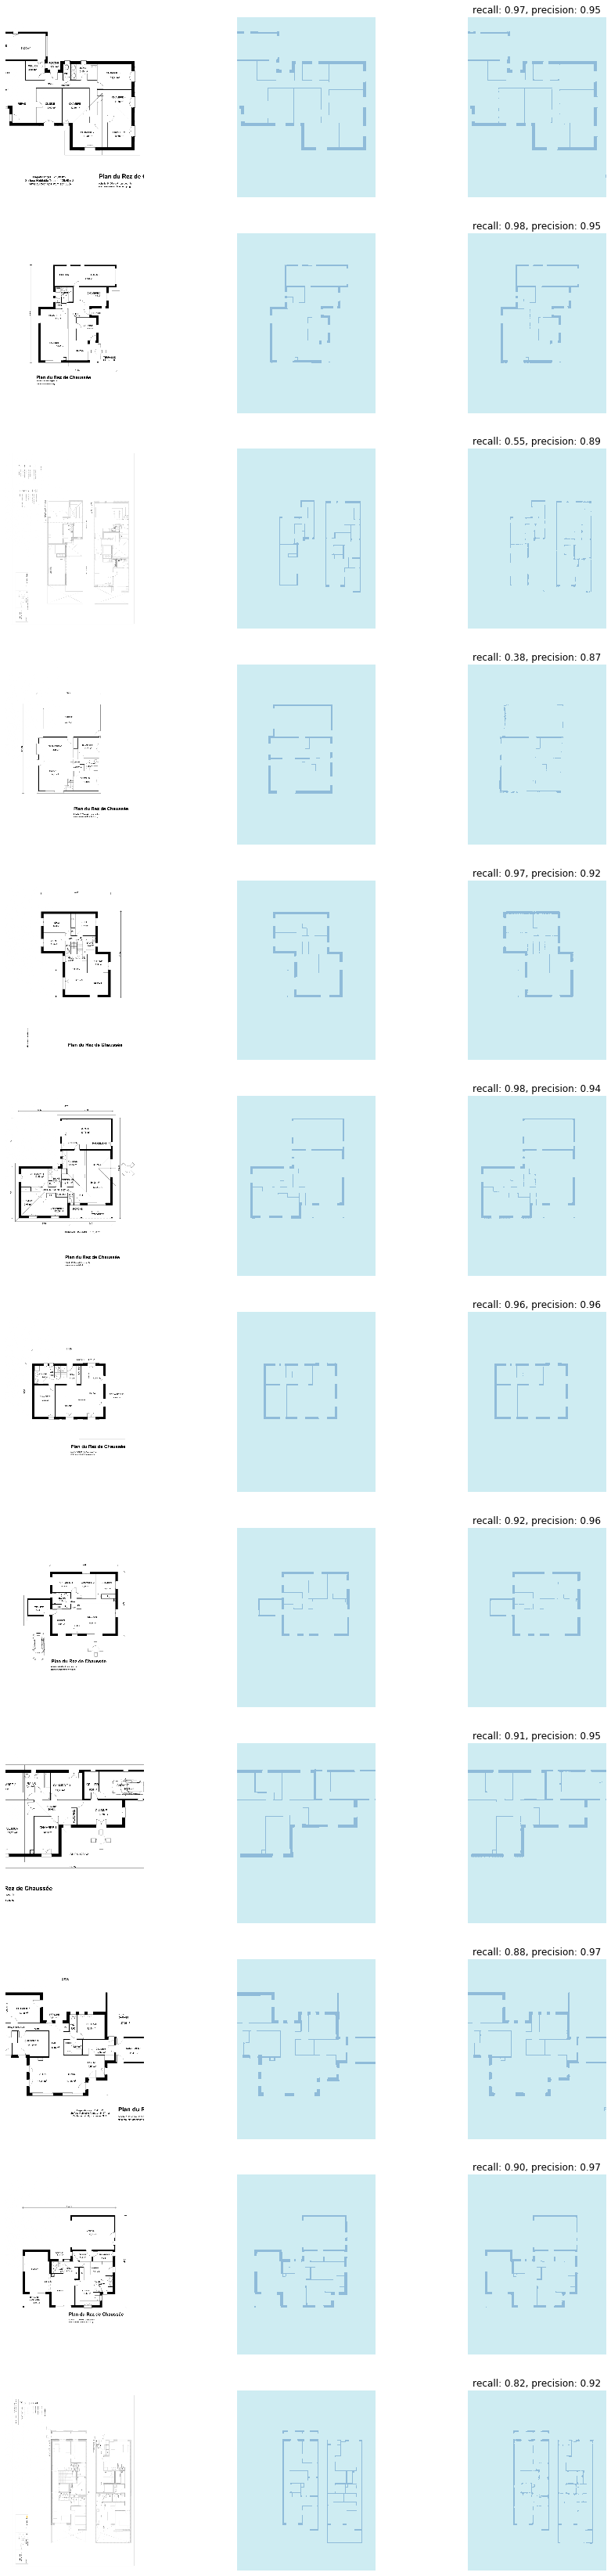

In [60]:
show_results()

In [61]:
learn.unfreeze()

In [62]:
lrs = slice(lr/400,lr/40)

In [63]:
learn.fit_one_cycle(5, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_wall,precision,recall,time
0,0.013950,0.015888,0.994130,0.945891,0.869364,00:30
1,0.014878,0.015461,0.994212,0.946914,0.871111,00:29
2,0.014456,0.016144,0.994004,0.953988,0.858020,00:30
3,0.014512,0.014905,0.994537,0.940648,0.887938,00:31
4,0.014240,0.015269,0.994304,0.950790,0.870695,00:30


In [64]:
learn.save('stage-2')

In [65]:
# learn.destroy()
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()
learn.load('stage-2');

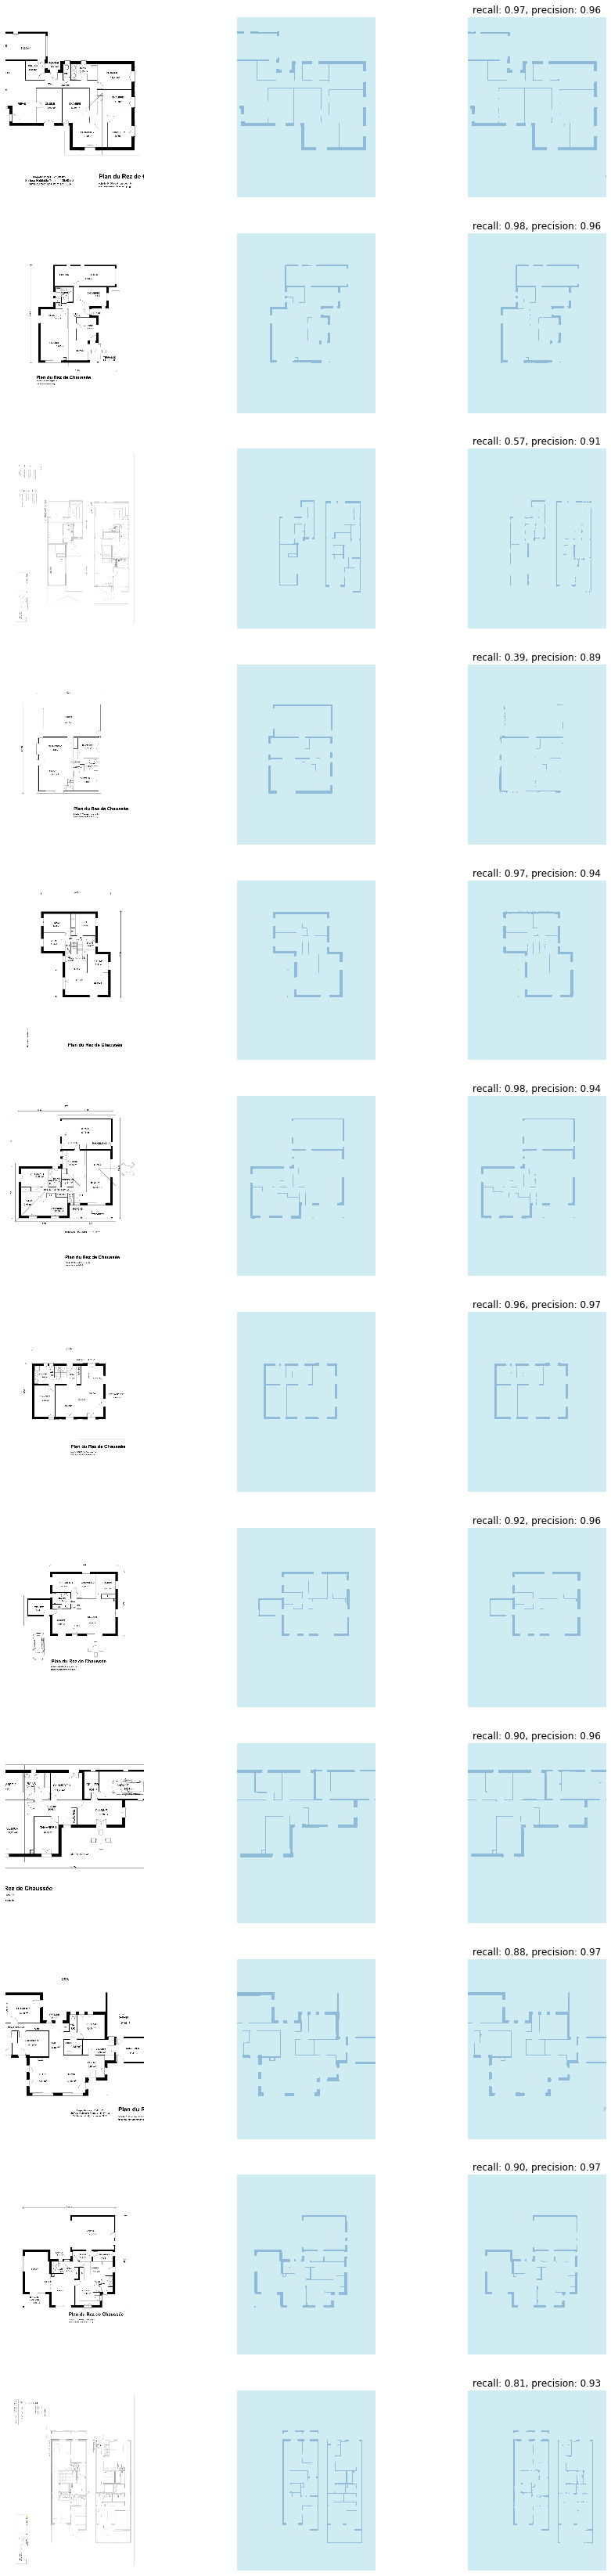

In [66]:
show_results()

# Manual convolutions

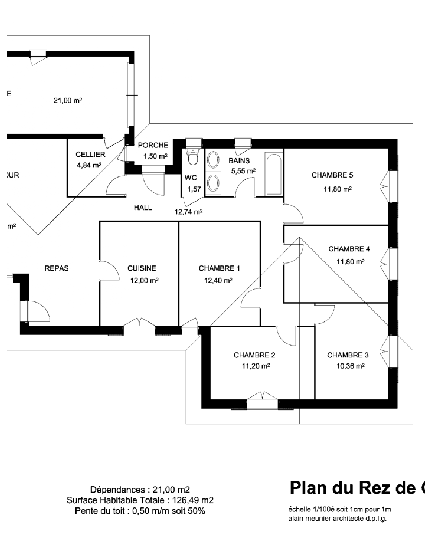

In [26]:
idx=0
x,y = data.valid_ds[idx]
x.show(figsize=(10,10))
#data.valid_ds.y[idx]

In [27]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [28]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [29]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 922, 708])

In [30]:
t[None].shape

torch.Size([1, 3, 922, 708])

In [31]:
edge = F.conv2d(t[None], k)

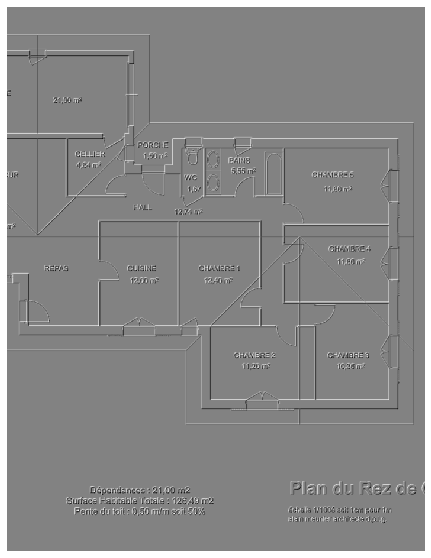

In [33]:
show_image(edge[0], figsize=(10,10));

# Activation visualisation

In [73]:
learn.load('stage-2')
learn_full = learn.to_fp32()
learn_full.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 461, 354]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 461, 354]       128        True      
______________________________________________________________________
ReLU                 [64, 461, 354]       0          False     
______________________________________________________________________
MaxPool2d            [64, 231, 177]       0          False     
______________________________________________________________________
Conv2d               [64, 231, 177]       36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 231, 177]       128        True      
______________________________________________________________________
ReLU                 [64, 231, 177]       0          False     
__________________________________________________

In [75]:
m = learn_full.model.eval()

In [76]:
m[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [77]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [78]:
xb.shape

torch.Size([1, 3, 922, 708])

In [79]:
from fastai.callbacks.hooks import *

In [80]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            #preds[0,int(cat)].backward()
    return hook_a,hook_g

In [81]:
hook_a,hook_g = hooked_backward()

In [82]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 29, 23])

In [83]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([29, 23])

In [89]:
def show_heatmap(hm, figsize=(3,3)):
    _,ax = plt.subplots(figsize=figsize)
    xb_im.show(ax, figsize)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

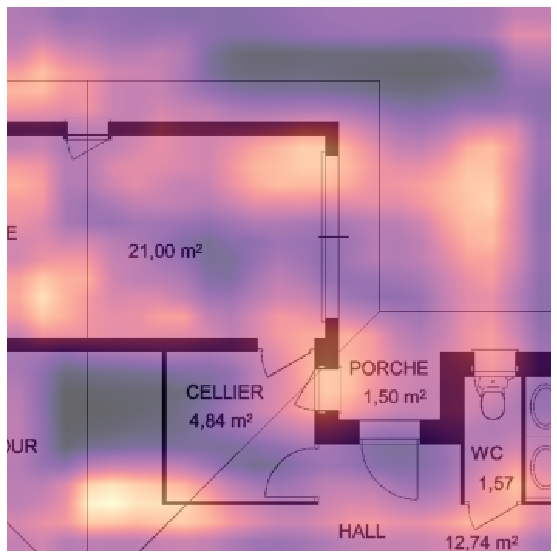

In [90]:
show_heatmap(avg_acts, figsize=(10,10))